In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as sk
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from RegscorePy import *
from scalingAnalysis import *
from IPython.core.debugger import set_trace
##### This script is to run basic scaling law analyses

# User Configs


In [2]:
years = "2000-2005"

#what features to analyze
#feats = ["Total GDP","Violent Crime","Total Robberies"]#"Number of Visitors (Estimate by Accommodation GDP)"]
feats = ["GDP","Unemployment","Patents"]#["Patents"]#["GDP/Job","GDP"]#,"Total Employed"]#["GDP","Disposable Income per Household","Unemployment"]

# feats to be plotted on a linear regression rather than log-log
linearFeats = ["Gini Index"]


# what type of connectivity to use for residual plotting    
connectivityTags = {
    #"Connectivity (asymmetric)":1#,
    "Connectivity (symmetric)":1#,
    #"Global Firm Presence (without Connectivity)":1.0
    #'Services GDP':1
    #'Connectivity (Presence times Degree)':1.0
    #"Air Traffic":1.0
}

# what to call this combination of connectivities in output file
connectivityLbl = "Global Firm Connections (Symmetric)"#"Air Traffic"#"Global Firm Connections (Symmetric)""Isolated Firm Presence"#

#includeTag = 'ALL/SEPARATE' # this plots all countries on individual country plots
includeTag = 'ALL/COMBINED' # this plots all countries together
#includeTag = 'ALL/COMBINED+SEPARATE' # this plots each country individually plus all of EU as one (TODO: Not yet implemented)
#includeTag = 'LIST' # this allows manual lists of countries in "countries" above


# minimum number of datapoints to plot
dataPlotMin = 7

# The "N" in the scaling equation; normally population
scaling_pop = "Population"#"Total Employed"

# what countries to analyze. 
countries = [[
'United States'
#'Australia',
#'Canada',
#'Germany',
#'Spain',
#'France',
#'United Kingdom',
#'Italy',
#'United States (Census)'
]]

# set true if running on US census data
USData = False

# max size for point in plotting correlations
maxSize = 350

# process run parameters and read in Data

In [3]:
if includeTag == 'ALL/SEPARATE':
    countries = []
    #for country in allCountries:
    countries = list(map(lambda x: [x], allCountries))
elif includeTag == 'ALL/COMBINED':
    countries = [allCountries]
elif includeTag == 'LIST':
    countries = countries
else:
    print("WHAT COUNTRIES DO YOU WANT?")

# map, mapping countryname to dataframe
data = {}

# TODO: Include error bars

# input data file
fIn = "Features"+years.replace("-","_")+".xls"


if USData:
    countries = [["United States (Census)"]]
    allCountries = countries[0]

for country in allCountries:
    data[country] = pd.read_excel(fIn,sheet_name=country)

In [73]:
#for country in allCountries:
#    data[country]["GDP/Job"] = data[country]["GDP"]/data[country]["Total Employed"]
#
#with pd.ExcelWriter("newFeatures.xls") as writer:    
#    for country in data:
#        data[country].to_excel(writer, sheet_name=country)



# Run Analysis

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Canada
Germany
France
United Kingdom
Italy
United States
fitting  Canada
fitting  Germany
fitting  France
fitting  United Kingdom
fitting  Italy
fitting  United States


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

r = 0.5478145179650075
p = 6.921465576480887e-08


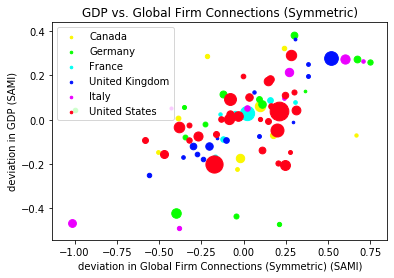

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

fitting  France
fitting  Italy
fitting  United States


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

r = -0.47961233762401007
p = 0.0011367665140414377


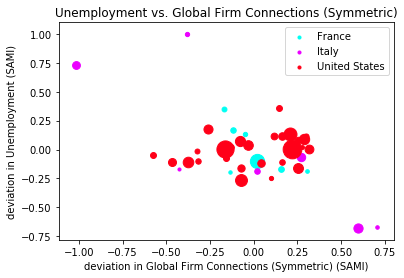

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

fitting  Germany
fitting  France
fitting  United Kingdom
fitting  Italy


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

r = 0.46263141214267767
p = 0.0015673198120120372


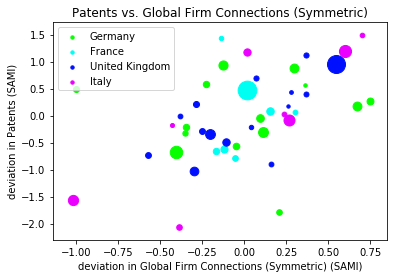

In [11]:
cMap = plt.cm.get_cmap('hsv',len(["Canada","Germany","France","United Kingdom","Italy","United States"])+1)
cMap_dict = {}
i = 0
for country_lbl in ["Canada","Germany","France","United Kingdom","Italy","United States"]:
    country_lbl = country_lbl#[0]
    print(country_lbl)
    i += 1
    cMap_dict[country_lbl] = cMap(i)

# do analysis seperately for every feature
for feat in feats:

    # ignore connectivity vs connectivity
    if feat in connectivityTags.keys():
        continue


    # TODO: What about countries being plotted on linear-linear plot?
    # for every set of countries to plot together, reset residuals and connectivities to be plotted together
    for countryList in countries:
        residuals = {}
        connectivities = {}
        pops = {}
        allPops = []
        allResiduals = []
        allConnectivities = []
        countriesWithData = []
        # for each country SEPARATELY, run fits on scaling relations to get residuals, collect with connectivity data
        for country in countryList:
 
            dataToPull = [scaling_pop,feat]
            for connectivityTag in connectivityTags.keys():
                dataToPull.append(connectivityTag)
            plotData = data[country][dataToPull].dropna()

            # skip over countryLists without data
            if plotData.empty:
                msg = 'No Data for country {} and feature {}'.format(country,feat)
                #print(msg)
                continue
                
            # skip over countryLists with less than a set number of datapoints
            if len(list(plotData.index)) < dataPlotMin:
                msg = 'Not Enough Data for country {} and feature {}'.format(country,feat)
                #print(msg)
                continue
        
            countriesWithData.append(country)

            pops[country] = plotData[scaling_pop]
            allPops = allPops + list(pops[country])

            print("fitting ",country)
            # get scaling parameters
            Beta,y0 = getScaleParams(plotData,feat,linearFeats,scaling_pop=scaling_pop) 
            #plt.figure()
            ## sanitycheck for fittings
            # pop = list(plotData["Population"])
            # plt.plot(list(map(lambda x: np.log(x),pop)),list(map(lambda x: np.log(x),list(plotData[feat]))), 'ro')
            # x_space = np.linspace(np.log(np.min(pop)),np.log(np.max(pop)),len(pop))
            # plt.plot(x_space, Beta*x_space+y0, '--k')
            # plt.show()
            # plt.close()
            featVals = list(plotData[feat])

            residuals[country] = getResiduals(plotData[scaling_pop],featVals,Beta,y0,featMean=np.average(featVals))

            

            newConnectivities = getNetConnectivities(connectivityTags,plotData,scaling_pop=scaling_pop)
            #newConnectivities = plotData['Ratio of Global Econ']
                
            connectivities[country] = list(newConnectivities)#list(plotData[connectivityTag])
            
            allResiduals = allResiduals + list(residuals[country])
            allConnectivities = allConnectivities + list(connectivities[country])
    
        if len(allResiduals) == 0:
            continue
        
        countryListName = ""
        if includeTag == 'ALL/COMBINED':
            countryListName = "AllCountriess"
        else:
            for country in countryList:
                app = country + "-"
                countryListName = countryListName + (app)
        if USData:
            countryListName = "US"

#         lbl = countryListName[:-1]+"_"+feat+"_"+"3D_Plot.png"
#         plot3DMap(features=plotData[feat],x=pops[country],conns=plotData[connectivityLbl],lbl=lbl,feat=feat)
        
        outDir = "Figures/ConnectivityRelations/"+years

        outName = outDir + "/" + countryListName[:-1]+"_"+feat+"_"+connectivityLbl+ "_"+resCalc+ "PRESENTATION.png"
        #outName = outDir + "/" + countryListName[:-1]+"_"+"GDPperJob"+"_"+connectivityLbl+ "_"+resCalc+ "PRESENTATION.png"
        outName = outDir + "/AllCountries_" + feat+ "_Connectivity"
        plt.figure(outName)
        # 
        #residuals = connScale(residuals)
        
        maxPop = np.max(allPops)
        sizeCoeff = maxSize/maxPop
        minSize = sizeCoeff*np.min(allPops)
        # TODO: Label colors better (Hacky right now)
        for country in countriesWithData:
            first = True
            color = cMap_dict[country]
            for c,r,p, in zip(connectivities[country],residuals[country],pops[country]):
                size = p*sizeCoeff
                if first:
                    plt.scatter(c,r,c=color,s=size)
                    plt.scatter(c,r,c=color,s=minSize,label=country)
                    first = False
                else:
                    plt.scatter(c,r,c=color,s=size)
            i = i + 1  

        #loggedRes = list(map(lambda x: logVals))

        rVal,pVal = pearsonr(allConnectivities,allResiduals)
        pReport = "r = {}\np = {}".format(rVal,pVal)
        print(pReport)
        #plt.text(0.6,0.2,pReport,fontsize=12,transform=plt.gca().transAxes)
        xLbl = "deviation in " +connectivityLbl+" ("+resCalc+")"
        #xLbl = connectivityLbl
        yLbl = "deviation in "+feat+" ("+resCalc+")"
        plt.xlabel(xLbl)
        plt.ylabel(yLbl)
        plt.legend()
        ttl = feat + " vs. "+connectivityLbl
        plt.title(ttl)
        #plt.gca().set_yscale("log")
        #plt.gca().set_xscale("log")
        plt.show()
        #plt.savefig(outName)
        plt.close()

        
        



## Define separate analysis functions

In [40]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

def plot3DMap(features=None,x=None,conns=None,lbl="UNKNOWN",feat="UNKNOWN"):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    print(x,conns,features)
    print(len(x),len(conns),len(features))
    ax.scatter(x, conns, features)

    ax.set_xlabel('Population')
    ax.set_ylabel('Connectivity')
    ax.set_zlabel(feat)
    plt.title(lbl)
    #TODO: Plot fits from A) null model of two independent scaling variables B) test model where two dependent variables are correlated

    plt.show()


In [ ]:
import re
# determine if two cities, with names potentially spelled differently and/or 
# in different languages, are the same cities. Cities with more than one way 
# of spelling will have them separated by '/'
def cityNameMatch(name1,name2):
    newNames = []
    for name in [name1,name2]:
        newName = name.lower()
        newName = newName.replace("(nuts 2010)","")
        newName = newName.replace("greater ","")
        newName = newName.replace(" (greater)","")
        newNameList = re.split('/|-',newName)
        newNames.append(newNameList)
        
    name1List = newNames[0]
    name2List = newNames[1]
    for subName1 in name1List:
        for subName2 in name2List:
            #if (subName1 in subName2 or subName2 in subName1) and not subName1.strip() == subName2.strip():
            #    print("edge case matching - %s , %s", (subName1, subName2))
            #if (subName1 in subName2) or (subName2 in subName1):
            if subName1.strip() == subName2.strip():
                return True
    return False






conns = pd.read_excel("Data/da11.xls").set_index("Cities")



        
    
degrees = {}
for firm in conns.columns:
    filteredPresences = conns[conns[firm] != 0]
    #print(filteredPresences[firm])
    degrees[firm] = len(list(filteredPresences[firm]))
    #newConnectivity.append(degree)
    #print(firm,nCities,len(list(conns[firm])))

    
#allCities = []
#
#for country in allCountries:
#    allCities = allCities + list(data[country]["City"])
#    
#for city in conns.index:
#    match = False
#    for loggedCity in allCities:
#        if cityNameMatch(city,loggedCity):
#            match = True
#            continue
#    if not match:
#        conns = conns.drop(city)
    
    
for city in conns.index:
    for firm in conns.columns:
        conns[firm][city] = degrees[firm] * conns[firm][city]
    
newConns = pd.DataFrame(index=conns.index,columns=["Presence times Degree"])
for city in conns.index:
    newConn = np.sum(conns.loc[city])
    newConns["Presence times Degree"][city] = newConn
    
maxVal = np.max(newConns["Presence times Degree"])

newConns['Presence times Degree'] = newConns["Presence times Degree"]/maxVal

print(newConns)

    
#plt.figure()
#plt.hist(nCities,bins=30)
#print(np.min(nCities))
#plt.xlabel("Nodal degree (Number of cities in which a firm has presence)")
#plt.ylabel("Number of firms")
#plt.savefig("Figures/ConnectivityRelations/firmNodalDegree.png")
#plt.close()

In [ ]:
newConns.to_excel("ConnectivitiesNew.xls")